In [1]:
%load_ext cython
import numpy as np
import pyximport
from importlib import reload
import sys
import os
import h5py
import matplotlib.animation as animation
from tqdm.auto import tqdm
from cbclib.bin import *
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2abda03eef10>)

In [285]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', 'LSD', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'median_filter', 'np']


In [286]:
# data = np.ones((10, 10))
data = np.arange(20)
mask = np.ones(data.shape, dtype=bool)
mask[::2] = 0
%time background = dev.median_filter(data, (10,), num_threads=1, mode='reflect')

CPU times: user 1.12 ms, sys: 1.14 ms, total: 2.25 ms
Wall time: 1.59 ms


In [287]:
background

array([2.32187995e-310, 4.66707001e-310, 2.32187995e-310, 2.32187987e-310,
       2.32177708e-310, 2.32187987e-310, 2.32187987e-310, 2.32187987e-310,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [279]:
%time ndimage.median_filter(data, (30,), mode='reflect')

CPU times: user 193 µs, sys: 151 µs, total: 344 µs
Wall time: 286 µs


array([ 7,  7,  7,  7,  7,  7,  7,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 92, 92, 92, 92, 92, 92, 92])

In [20]:
num_threads = 64
pix_size = 7.5e-05

In [4]:
with h5py.File("results/scan_corrected_00135.h5", 'r') as cxi_file:
    data = cxi_file['data/data'][()]
print(data.shape)

(101, 2167, 2070)


In [5]:
scan_num = 209
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_file = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])[0]
with h5py.File(h5_file, 'r') as cxi_file:
    whitefield = cxi_file['entry/data/data'][()]
vmin, vmax = 0, 1000000
whitefield = np.mean(whitefield * ((whitefield > vmin) & (whitefield < vmax)), axis=0)

In [6]:
scan_num = 211
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])

scan_size = 1441
n_scans = 11
file_size = 1000
frame_idx = 0
frames = []
for scan in range(n_scans):
    h5_idx = (frame_idx + scan_size * scan) // file_size
    h5_frame = (frame_idx + scan_size * scan) % file_size
    
    with h5py.File(h5_files[h5_idx], 'r') as cxi_file:
        frames.append(cxi_file['entry/data/data'][h5_frame])
data = np.stack(frames)

In [15]:
scan_num = 204
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_file = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])[0]

frames = []
for frame_idx in range(100):
    with h5py.File(h5_file, 'r') as cxi_file:
        frames.append(cxi_file['entry/data/data'][frame_idx])
data = np.stack(frames)

In [13]:
%time _ = ndimage.median_filter(data, (1, 3, 3))

CPU times: user 8.69 s, sys: 55.7 ms, total: 8.74 s
Wall time: 8.74 s


In [77]:
vmin, vmax = 0, 10000000
mask = (data > vmin) & (data < vmax)

In [14]:
bgd_mask = np.abs(data - 5 * whitefield) < np.sqrt(5 * whitefield)
%time background = median_filter(data, bgd_mask, axis=0, size=9, num_threads=num_threads)

CPU times: user 16 s, sys: 810 ms, total: 16.8 s
Wall time: 540 ms


In [24]:
arr.strides

(96, 32, 8)

In [33]:
arr.strides, arr.shape

((96, 32, 8), (3, 3, 4))

In [43]:
size = 36
arr = np.arange(size).reshape(3, 3, 4)
coordinates = np.zeros(3)

for i in range(arr.size):
    pointer = i * arr.itemsize
    print(pointer)
    for n in range(arr.ndim):
        print(pointer // arr.strides[n], end=' ')
        pointer -= (pointer // arr.strides[n]) * arr.strides[n]
    print('')

0
0 0 0 
8
0 0 1 
16
0 0 2 
24
0 0 3 
32
0 1 0 
40
0 1 1 
48
0 1 2 
56
0 1 3 
64
0 2 0 
72
0 2 1 
80
0 2 2 
88
0 2 3 
96
1 0 0 
104
1 0 1 
112
1 0 2 
120
1 0 3 
128
1 1 0 
136
1 1 1 
144
1 1 2 
152
1 1 3 
160
1 2 0 
168
1 2 1 
176
1 2 2 
184
1 2 3 
192
2 0 0 
200
2 0 1 
208
2 0 2 
216
2 0 3 
224
2 1 0 
232
2 1 1 
240
2 1 2 
248
2 1 3 
256
2 2 0 
264
2 2 1 
272
2 2 2 
280
2 2 3 


In [78]:
data_sum = np.sum(data * mask, axis=0)

<IPython.core.display.Javascript object>


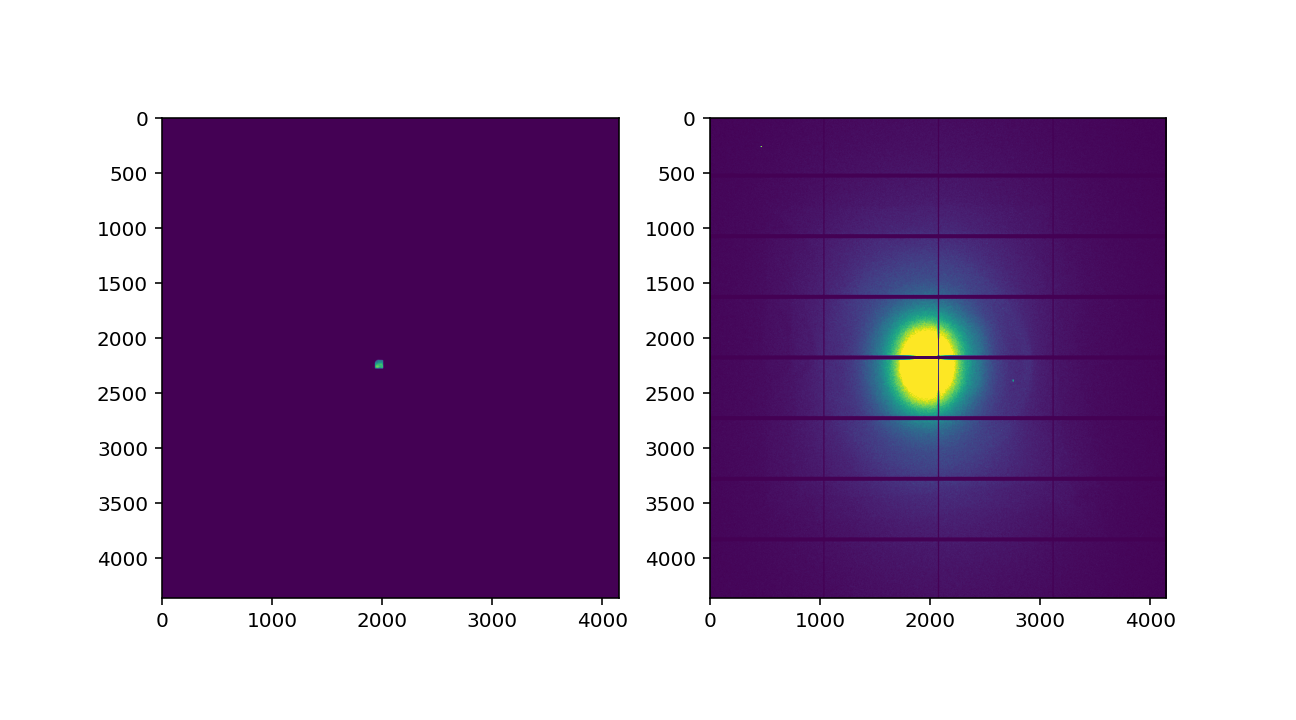

In [79]:
frame_idx = 10

%matplotlib notebook
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
axes[0].imshow(data_sum)
# axes[0].imshow(data[frame_idx] * mask[frame_idx], vmax=100000)
# axes[0].imshow(background[frame_idx], vmax=10)
# axes[1].imshow(np.where(whitefield, (wf_dyn[frame_idx] - whitefield) / whitefield, 0), vmax=0.5)
# axes[1].imshow(np.where(whitefield, (data[frame_idx] - whitefield) / whitefield, 0), vmin=0, vmax=1.)
# axes[1].imshow(wf_masked[frame_idx], vmin=0, vmax=10)
# axes[1].imshow(outliers[frame_idx], vmax=1.)
axes[1].imshow(5 * whitefield, vmin=0, vmax=10)
plt.show()

In [319]:
cor_data = data * mask / (whitefield + 1.)
cor_data = np.clip(cor_data, 0, cor_data.max())

In [47]:
cor_data = data * mask - background - np.sqrt(background)
cor_data = np.clip(cor_data, 0, cor_data.max())

In [80]:
cor_sum = cor_data.sum(axis=0)

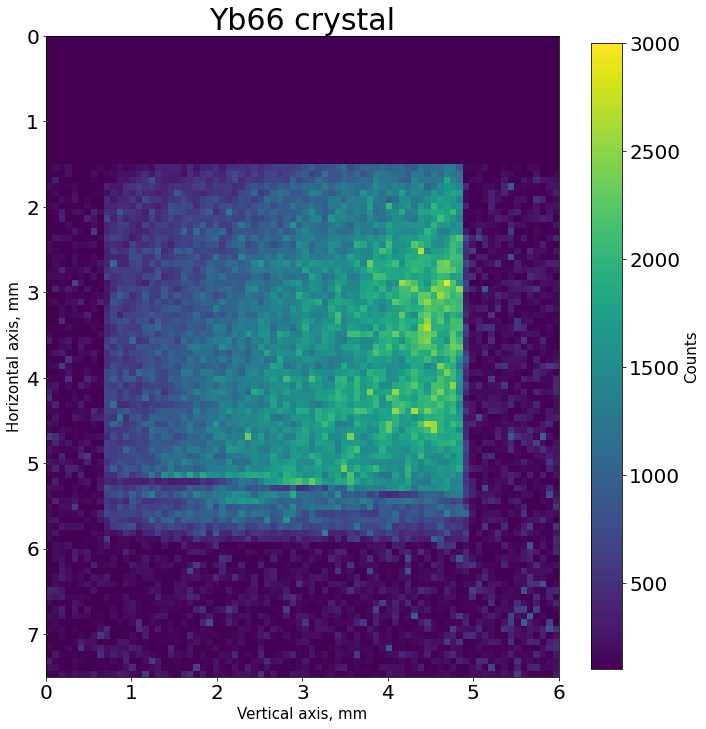

In [113]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(10, 11))
img = axes.imshow(cor_sum[2180:2280, 1610:1690], vmin=100, vmax=3000., 
                  extent=[0, 80e3 * pix_size, 100e3 * pix_size, 0], cmap='viridis')
axes.set_title('Yb66 crystal', fontsize=30)
axes.tick_params(labelsize=20)
axes.set_xlabel('Vertical axis, mm', fontsize=15)
axes.set_ylabel('Horizontal axis, mm', fontsize=15)
cbar = fig.colorbar(img, ax=axes, location='right', shrink=0.85)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Counts', fontsize=15)
plt.tight_layout()
# plt.show()
plt.savefig('yb66_diff_sum.jpg', dpi=150)

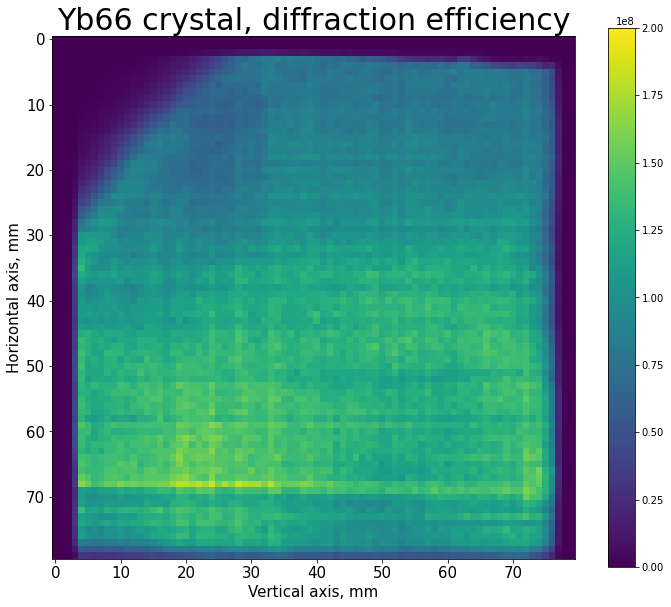

In [107]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
img = axes.imshow(data_sum[2200:2280, 1930:2010], vmin=0, vmax=200000000., cmap='viridis')
axes.set_title('Yb66 crystal, diffraction efficiency', fontsize=20)
axes.tick_params(labelsize=15)
axes.set_xlabel('Vertical axis, mm', fontsize=15)
axes.set_ylabel('Horizontal axis, mm', fontsize=15)
fig.colorbar(img, ax=axes, location='right', shrink=0.7)
plt.tight_layout()
plt.show()

In [174]:
cor_sum = cor_data.mean(axis=0)

In [165]:
edge_frame = gaussian_gradient_magnitude(cor_data[frame_idx], 1.5)

In [378]:
sigma = 5.
edge_ss = gaussian_filter(cor_data[frame_idx], (0, sigma), (0, 1), num_threads=64)
edge_fs = gaussian_filter(cor_data[frame_idx], (sigma, 0), (1, 0), num_threads=64)
image = np.sqrt(edge_ss**2 + edge_fs**2)

In [12]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', 'LSD', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'np']


In [46]:
lsd_obj = dev.LSD(scale=0.9, sigma_scale=0.9, log_eps=2)
vmin = np.sqrt(whitefield).mean()
vmax = 1.5
image = ndimage.median_filter(cor_data[frame_idx], (3, 3))
edges = (np.clip(image, vmin, vmax) - vmin) / (vmax - vmin) * 255
lines, labels = lsd_obj.detect(edges).values()

<IPython.core.display.Javascript object>


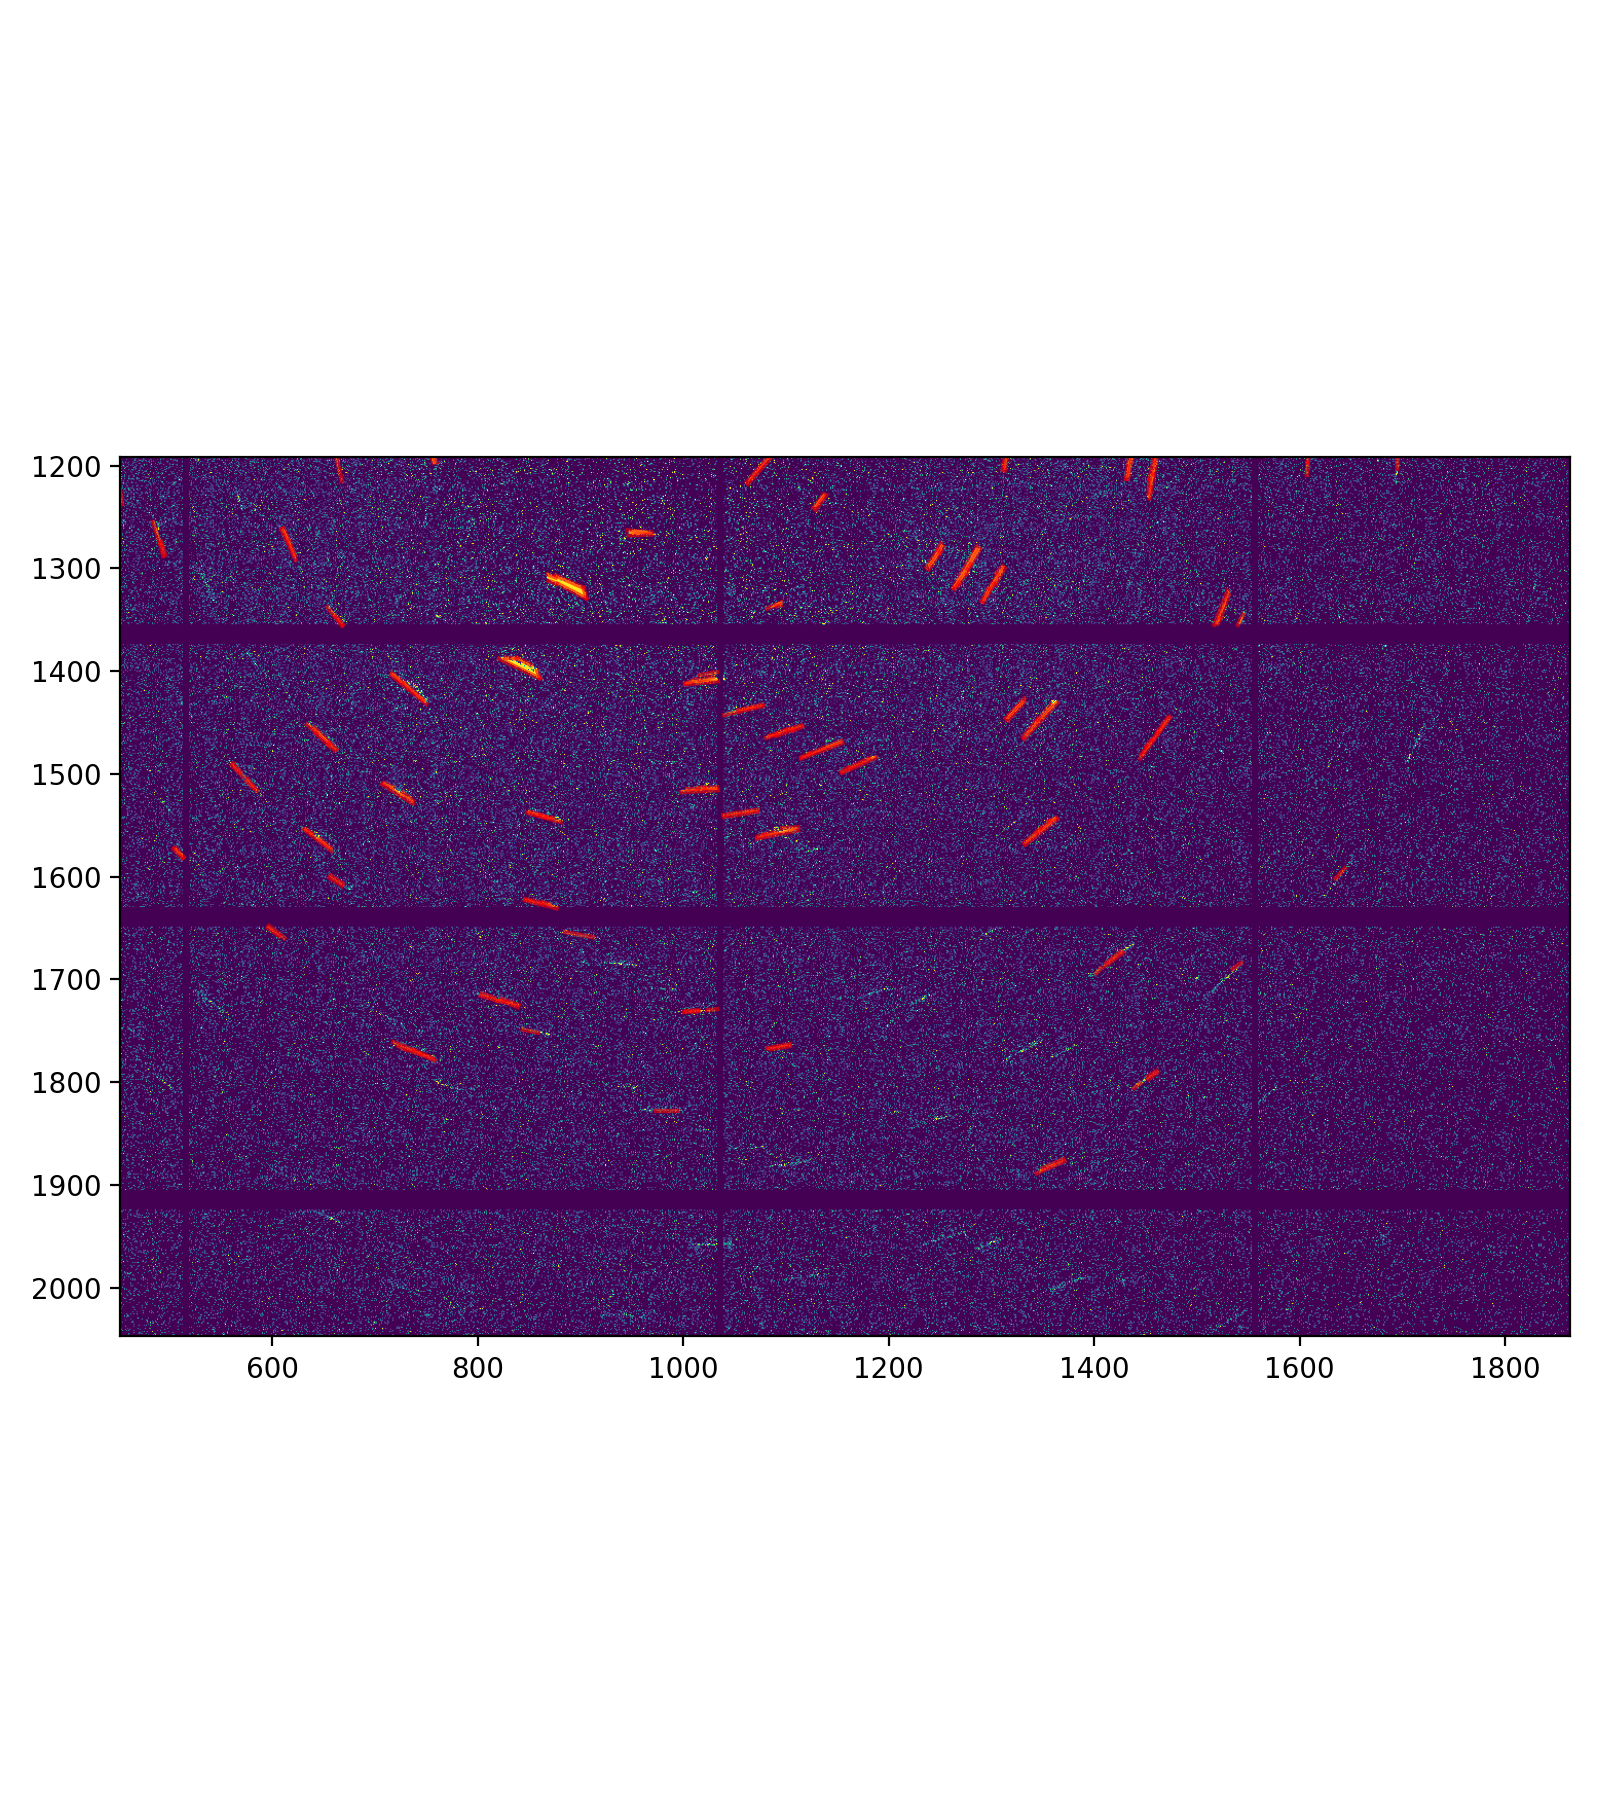

In [47]:
%matplotlib notebook
fig, axes = plt.subplots(1, 1, figsize=(8, 9))
axes.imshow(cor_data[frame_idx, ::2, ::2], vmin=0, vmax=2., cmap='viridis')
# axes.imshow(image, vmin=0, vmax=2., cmap='viridis')
for line in lines:
    axes.plot(line[0:4:2] // 2, line[1:4:2] // 2, c='r', alpha=0.6)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


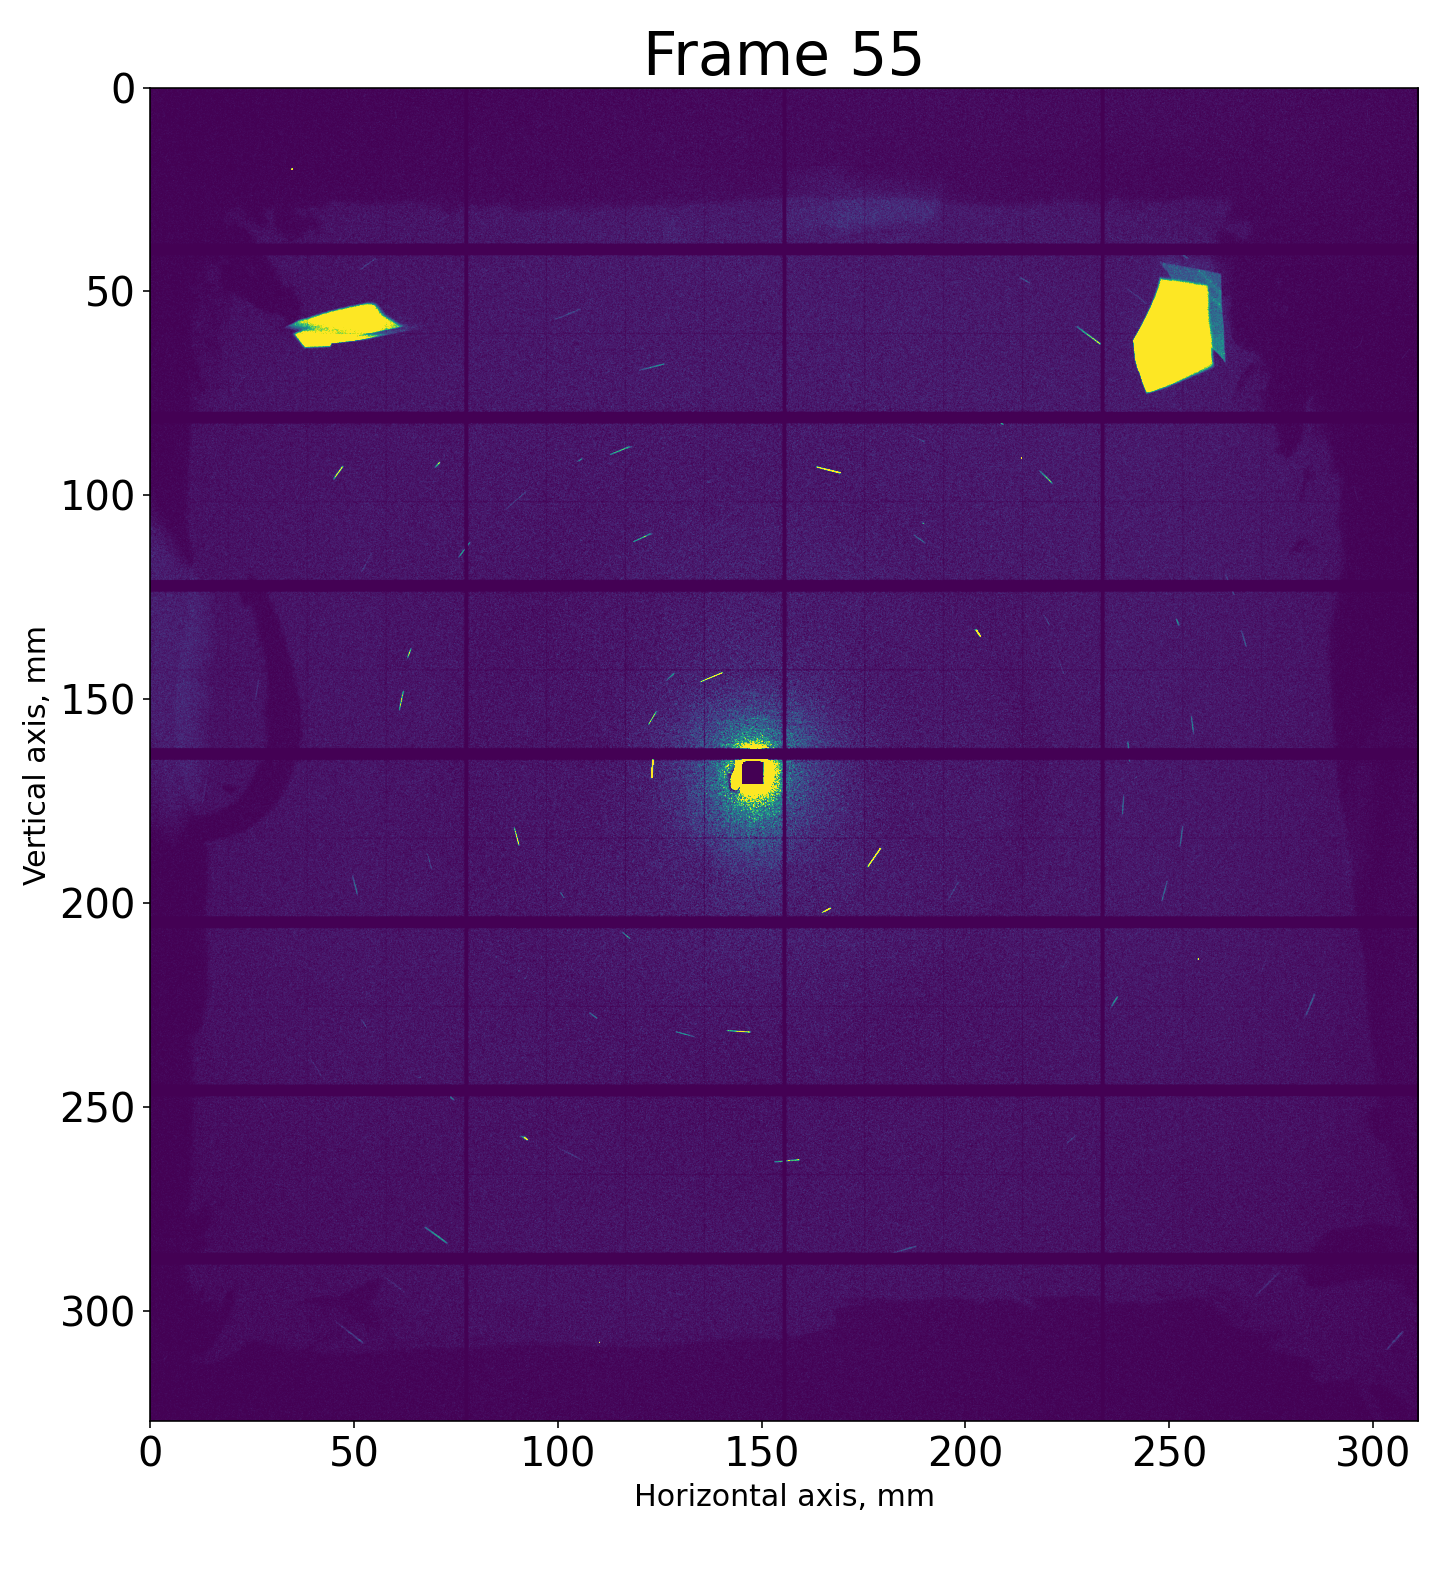

MovieWriter ffmpeg unavailable; using Pillow instead.


In [106]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10, 11))
ax.set_xlabel('Horizontal axis, mm', fontsize=15)
ax.set_ylabel('Vertical axis, mm', fontsize=15)
ax.tick_params(labelsize=20)
im = ax.imshow([[]], extent=[0, cor_data.shape[2] * pix_size * 1e3, cor_data.shape[1] * pix_size * 1e3, 0], vmin=0., vmax=20.)

def animate(i):
    im.set_data(cor_data[i])
    ax.set_title(f'Frame {i:d}', fontsize=30)
    return 

ani = animation.FuncAnimation(fig, animate, frames=cor_data.shape[0], interval=100, blit=False,
                              repeat_delay=1000)

plt.tight_layout()
# plt.show()
ani.save(f'Scan_{scan_num:d}.gif', dpi=100)